# Titanic - Machine Learning from Disaster

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [155]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [156]:
data_train.shape

(891, 12)

In [157]:
data_test.shape

(418, 11)

In [158]:
data_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [159]:
data_test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [160]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [161]:
print(data_train.isnull().sum())
print('----')
print(data_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [162]:
survived_count_train = data_train['Survived'].value_counts(normalize=True) * 100
print(survived_count_train)

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


In [185]:
train_copy = data_train.copy()
test_copy = data_test.copy()

In [186]:
train_copy['FamilySize'] = train_copy['SibSp'] + train_copy['Parch'] + 1
test_copy['FamilySize'] = test_copy['SibSp'] + test_copy['Parch'] + 1

train_copy['Alone'] = (train_copy['FamilySize'] == 1).astype('category')
test_copy['Alone'] = (test_copy['FamilySize'] == 1).astype('category')

train_copy['HasCabin'] = (~data_train['Cabin'].isna()).astype(int)
test_copy['HasCabin'] = (~data_test['Cabin'].isna()).astype(int)

train_copy['Title'] = train_copy['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_copy['Title'] = test_copy['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [187]:
train_copy.dropna(subset=['Embarked'], inplace=True)

title_age_means = train_copy.groupby('Title')['Age'].mean()


train_copy['Age'] = train_copy.apply(
    lambda row: title_age_means[row['Title']] if pd.isna(row['Age']) else row['Age'], axis=1
)

test_copy['Age'] = test_copy.apply(
    lambda row: title_age_means.get(row['Title'], train_copy['Age'].mean()) if pd.isna(row['Age']) else row['Age'],
    axis=1
)

fare_means = train_copy.groupby(['Pclass','Embarked'])['Fare'].mean()

train_copy['Fare'] = train_copy.apply(
    lambda row: fare_means[(row['Pclass'], row['Embarked'])] if pd.isna(row['Fare']) else row['Fare'], axis=1
)

test_copy['Fare'] = test_copy.apply(
    lambda row: fare_means.get((row['Pclass'], row['Embarked']), train_copy['Fare'].mean()) if pd.isna(row['Fare']) else row['Fare'],
    axis=1
)
train_copy['AgeGroup'] = pd.cut(train_copy['Age'], bins=[0,12,18,35,60,100], labels=['Child','Teen','Adult','MidAge','Senior'])
test_copy['AgeGroup'] = pd.cut(test_copy['Age'], bins=[0,12,18,35,60,100], labels=['Child','Teen','Adult','MidAge','Senior'])

In [188]:
print(train_copy.isnull().sum())
print('----')
print(test_copy.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FamilySize       0
Alone            0
HasCabin         0
Title            0
AgeGroup         0
dtype: int64
----
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FamilySize       0
Alone            0
HasCabin         0
Title            0
AgeGroup         0
dtype: int64


In [166]:
def show_survive_rate_by_categories(df, categorical_cols):
    sns.set_theme(style='whitegrid')
    plt.figure(figsize=(16, 4 * len(categorical_cols)))

    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(len(categorical_cols), 1, i)
        temp = df.groupby(col)['Survived'].mean().sort_values(ascending=False)
        sns.barplot(x=temp.index, y=temp.values, hue=temp.index, palette='viridis', legend=False)
        plt.ylabel('Survive Rate')
        plt.title(f'Survive Rate by {col}')
        plt.tight_layout()
    plt.suptitle('Survive Rate by Categorical Features', fontsize=18, y=1.02)
    plt.show()

C:\Users\karab\AppData\Local\Temp\ipykernel_14960\1023739056.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['Survived'].mean().sort_values(ascending=False)
C:\Users\karab\AppData\Local\Temp\ipykernel_14960\1023739056.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby(col)['Survived'].mean().sort_values(ascending=False)


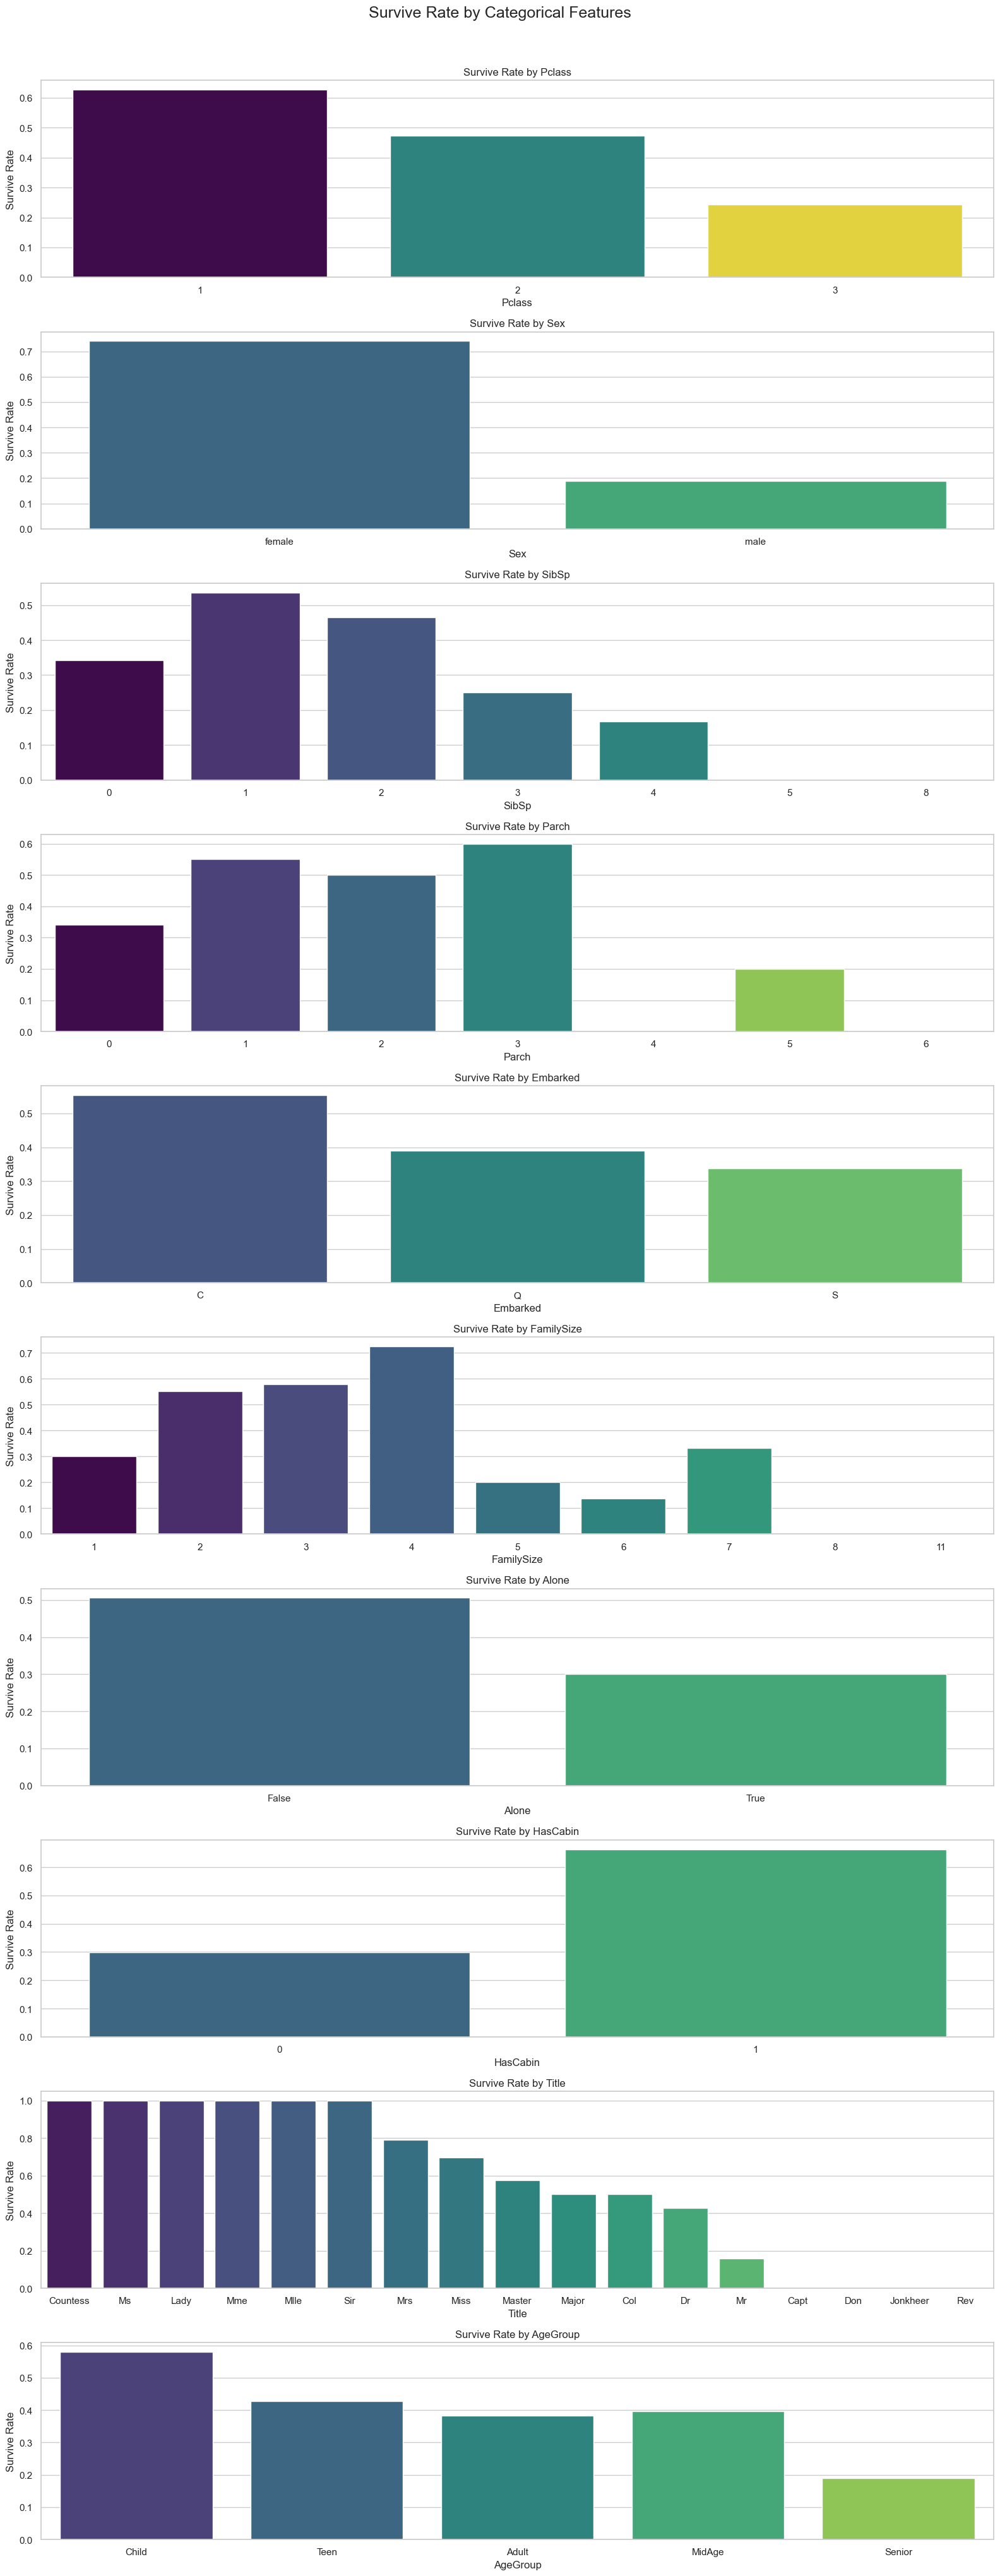

In [168]:
categorical_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'Alone', 'HasCabin', 'Title', 'AgeGroup']
show_survive_rate_by_categories(train_copy, categorical_cols)

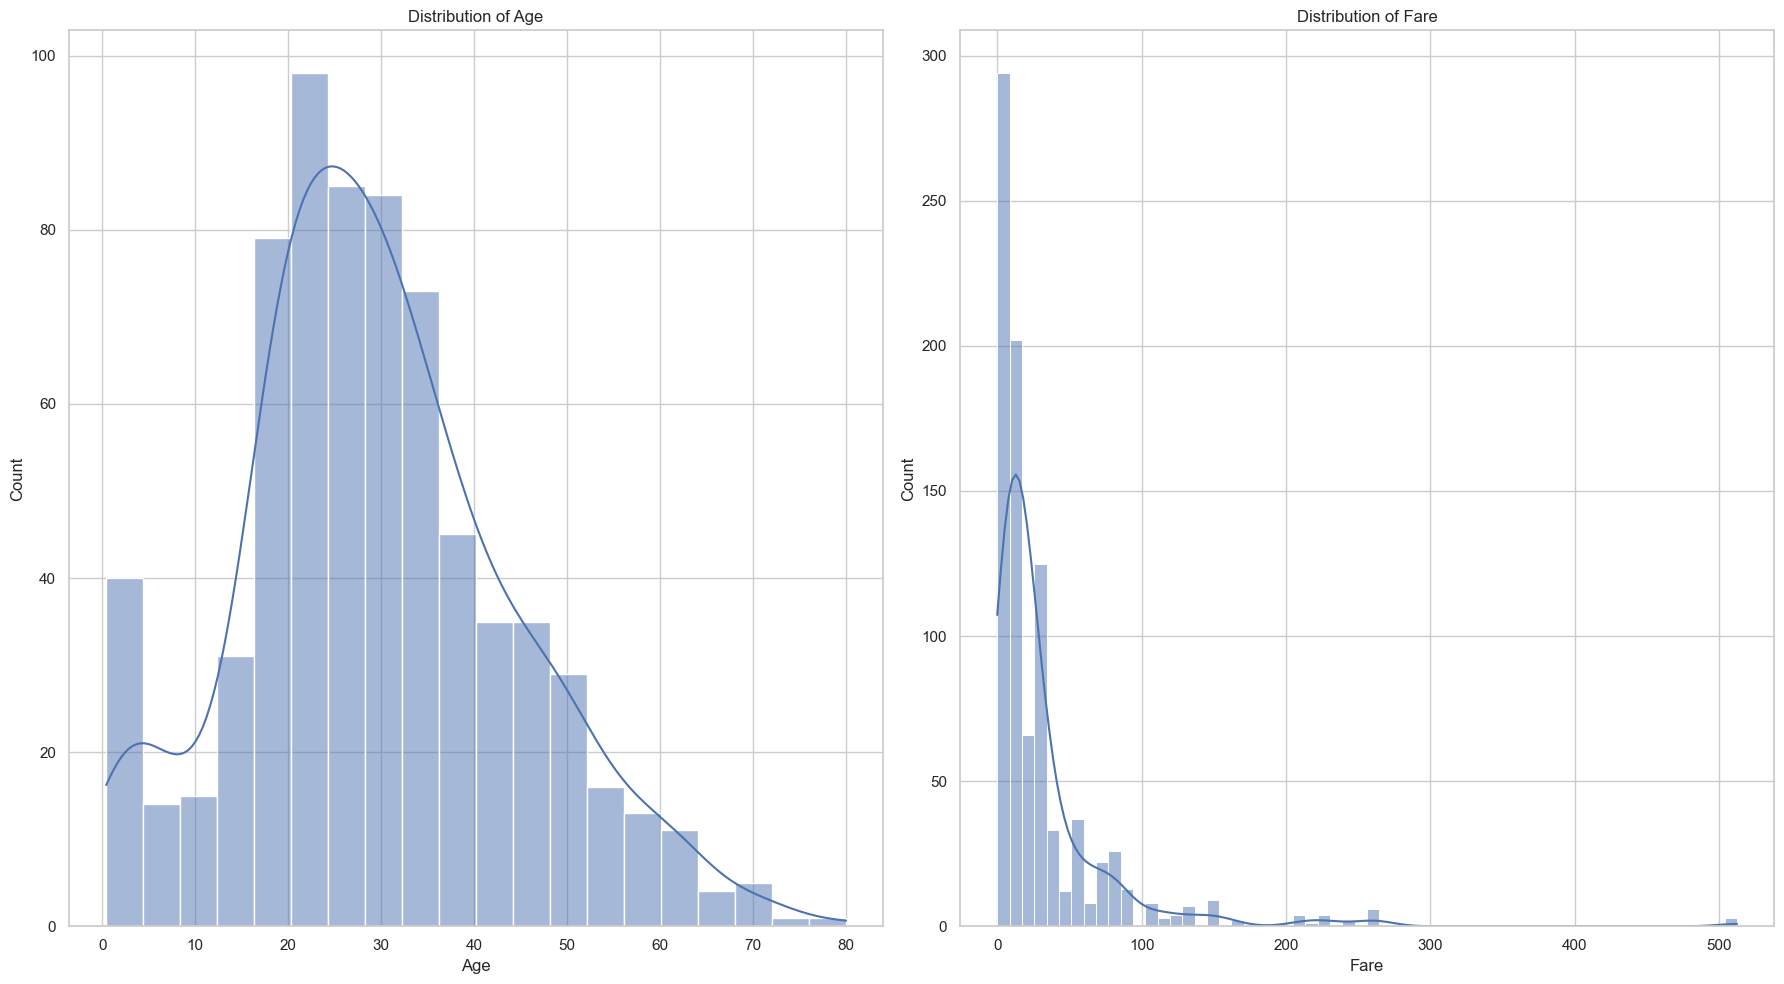

In [169]:
numerical_cols = ['Age', 'Fare']
plt.figure(figsize=(18, 10))
for i, col, in enumerate(numerical_cols, 1):
    plt.subplot(1, 2, i)
    sns.histplot(data_train[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

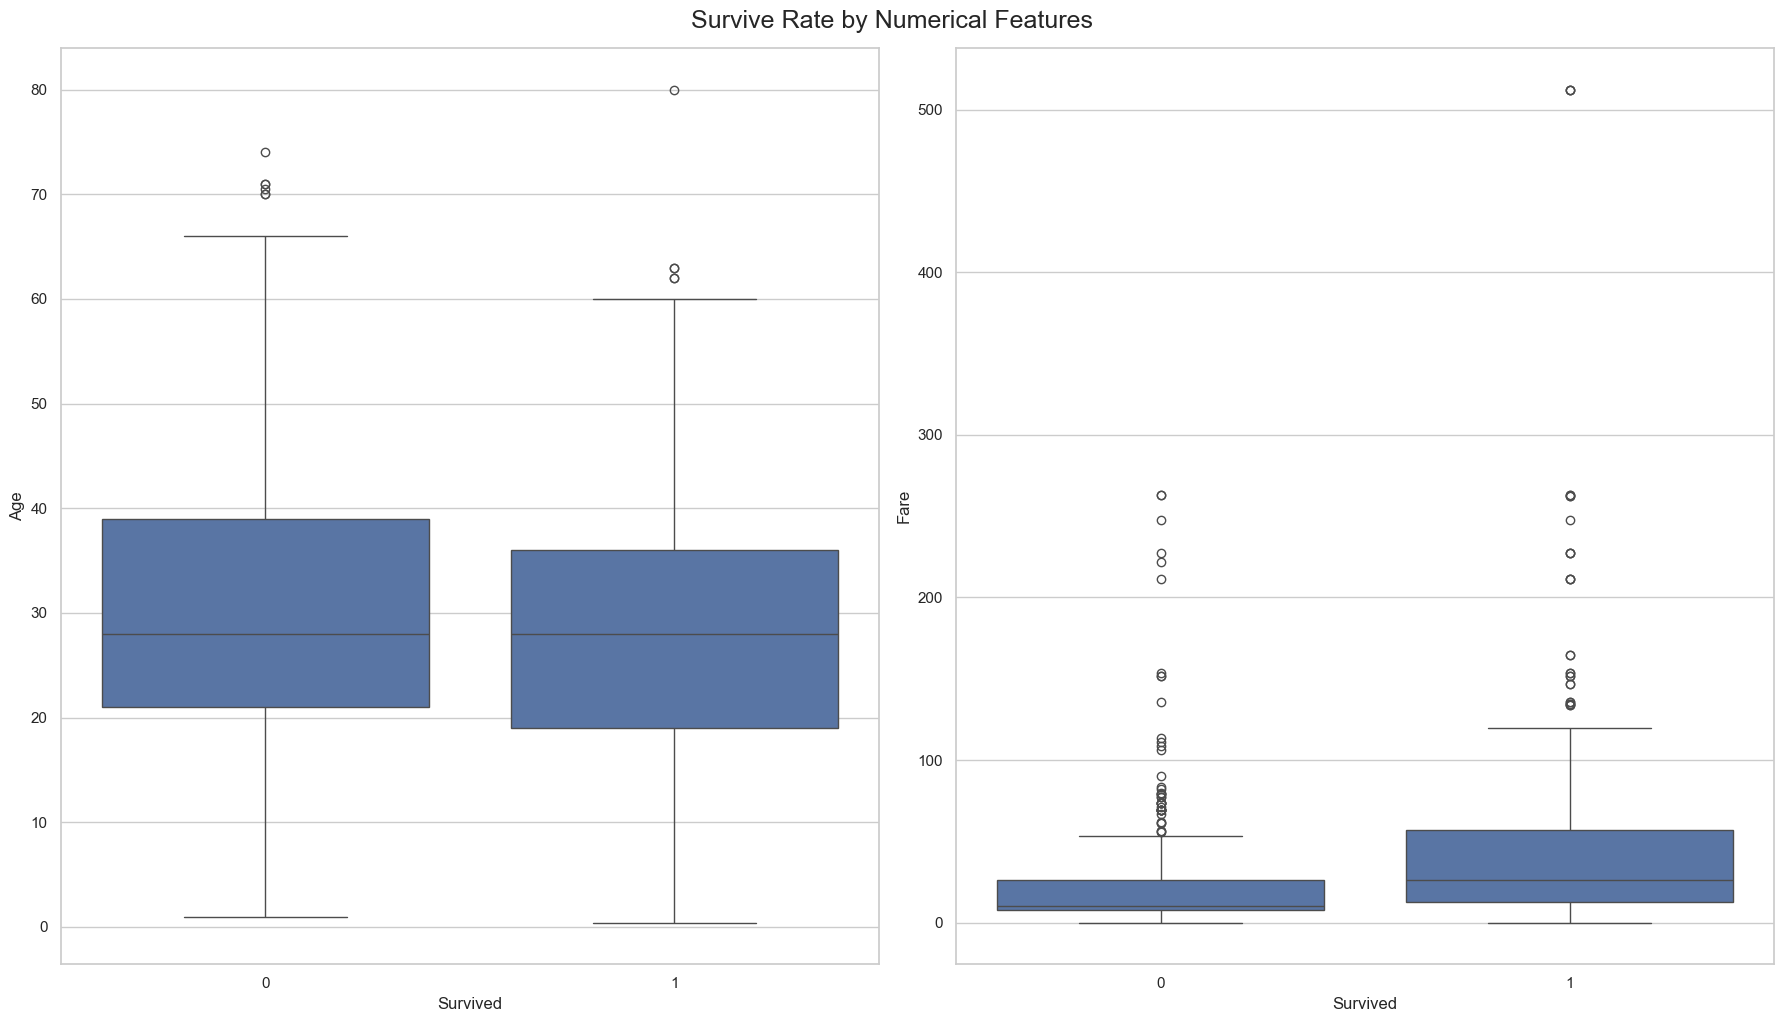

In [170]:
numerical_cols = ['Age', 'Fare']
plt.figure(figsize=(18, 10))
for i, col, in enumerate(numerical_cols, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x='Survived', y=col, data=data_train)
plt.tight_layout()
plt.suptitle("Survive Rate by Numerical Features", fontsize=18, y=1.02)
plt.show()

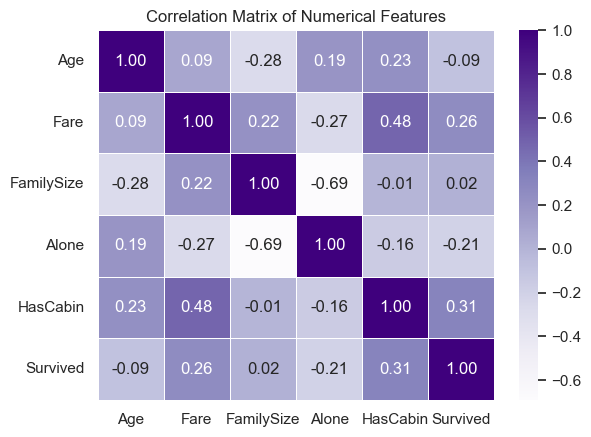

In [171]:
numerical_features = ['Age', 'Fare', 'FamilySize', 'Alone', 'HasCabin', 'Survived']
correlation_matrix = train_copy[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Purples', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [172]:
train_copy.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,HasCabin,Title,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,2,False,0,Mr,Adult


In [189]:
columns_to_drop = ['PassengerId', 'Name', 'SibSp', 'Parch',
                   'Ticket', 'Cabin', 'FamilySize', 'Age', 'Title']
train_copy.drop(columns_to_drop, axis= 1, inplace=True)
test_copy.drop(columns_to_drop, axis=1, inplace=True)

In [190]:
X_train = train_copy.drop('Survived', axis=1)
y_train = train_copy['Survived']

In [182]:
X_train.head(1)

,Pclass,Sex,Fare,Embarked,Alone,HasCabin,AgeGroup
0,3,male,7.25,S,False,0,Adult


In [195]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.05,
    depth=7,
    random_seed=42,
    verbose=100,
    eval_metric='Accuracy',
    early_stopping_rounds=3000,
    subsample=0.8,
    colsample_bylevel=0.8
)

model.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=['Sex', 'Embarked', 'Alone', 'AgeGroup', 'HasCabin'])
y_pred = model.predict(test_copy)

0:	learn: 0.8171589	test: 0.7865169	best: 0.7865169 (0)	total: 21.7ms	remaining: 1m 48s
100:	learn: 0.8860759	test: 0.8089888	best: 0.8202247 (32)	total: 2.33s	remaining: 1m 53s
200:	learn: 0.9127989	test: 0.8146067	best: 0.8202247 (32)	total: 4.59s	remaining: 1m 49s
300:	learn: 0.9282700	test: 0.8146067	best: 0.8202247 (32)	total: 7.12s	remaining: 1m 51s
400:	learn: 0.9381153	test: 0.8146067	best: 0.8202247 (32)	total: 9.18s	remaining: 1m 45s
500:	learn: 0.9437412	test: 0.8146067	best: 0.8202247 (32)	total: 11.3s	remaining: 1m 41s
600:	learn: 0.9493671	test: 0.8146067	best: 0.8202247 (32)	total: 13.3s	remaining: 1m 37s
700:	learn: 0.9563994	test: 0.8314607	best: 0.8314607 (664)	total: 15.4s	remaining: 1m 34s
800:	learn: 0.9648383	test: 0.8258427	best: 0.8314607 (664)	total: 17.5s	remaining: 1m 31s
900:	learn: 0.9704641	test: 0.8033708	best: 0.8314607 (664)	total: 19.6s	remaining: 1m 29s
1000:	learn: 0.9732771	test: 0.7865169	best: 0.8314607 (664)	total: 21.9s	remaining: 1m 27s
1100:	l

In [196]:
submission = pd.DataFrame({
    'PassengerId': data_test['PassengerId'],
    'Survived': y_pred.astype(int)
})

submission.to_csv('submission.csv', index=False)